###Double Lasso
We first set up our condition since most minimum wage change occured in 1997. We identify States that has a change in minimum wage in 1997 as treatment group.The rest of the states to control group. We use the MW to gather a new information line called Delta%changeMW. The original passage follows a three years before and five years after rotation. We use double lasso to enhance paralell assumption, in order to do that we select a median level of change occurs from treatment group from the parameter Deltachange%MW and compare use Double Lasso to compute it with all the components from control group.
###Data cleaning
We set the state with no change on minimum wage to pair with our result of 0 on our new parameter, and generate six changes for each state in order to use double lasso we need to set our new parameter with same quantity on our new parameter.
1. **Loading the Data**: The code starts by importing the pandas library as `pd`. It then reads an Excel file located at `excel_path` into a DataFrame named `df` using `pd.read_excel()`.

2. **Filtering States without 1997 Data**: It identifies states without data for the year 1997 and stores their names in `states_without_1997`. It then creates a new DataFrame `df_filtered` containing only the rows for states in `states_without_1997`.

3. **Saving Filtered Data to CSV**: The filtered DataFrame `df_filtered` is saved to a CSV file at `output_csv_path` using `to_csv()`.

4. **Filling Empty Years**: It creates an empty DataFrame `processed_df` and iterates over each state in `states_without_1997`. For each state, it creates a copy of the filtered DataFrame (`state_data`) and checks for missing years in the range 1990-1996. For any missing year, it creates a new row with zeros for `mw` and `changeinmw` and appends it to `state_data`. After filling missing years for each state, it appends the filled `state_data` to `processed_df`.

5. **Removing Duplicate Rows**: It sorts `processed_df` by state name and year and then removes duplicate rows keeping only the first occurrence for each state-year combination.

6. **Computing Change in Minimum Wage and Change Ratio**: It calculates the change in minimum wage (`changeinmw`) and the ratio of change in minimum wage to the previous year (`changeinmw_ratio`) for each state using `groupby()` and `diff()` functions. It handles cases of division by zero by replacing infinite values with zero.

7. **Saving Processed Data with Ratio**: The DataFrame `processed_df` with the added columns `changeinmw` and `changeinmw_ratio` is saved to a CSV file at `final_output_csv_with_ratio_path` using `to_csv()`.

8. **Importing Libraries**: It imports `pandas` as `pd` and the `LassoCV` class from `sklearn.linear_model`.

9. **Creating Arkansas Template**: It creates a DataFrame `arkansas_template` containing years 1990-1995 and assumed values for `changeinmw`.

10. **Reading Final Processed Data**: It reads the final processed data with ratios from the previously saved CSV file into `final_df`.

11. **Filling Empty Years in Final Data**: It creates an empty DataFrame `filled_final_df` and iterates over each state in `final_df`. For each state, it checks for missing years in the range 1990-1995 and fills them with zeros for `changeinmw`. It then appends the filled `state_data` to `filled_final_df`.

12. **Running Double Lasso and Finding Most Similar State**: It initializes variables `best_state` and `best_score` to store the state with the highest Lasso score. It iterates over each state in `filled_final_df` (excluding Arkansas) and selects the years common to both the current state and the Arkansas template. It then performs Lasso regression using `LassoCV` on the selected data and calculates the score. If the score is higher than the current best score, it updates `best_score` and `best_state`.

13. **Outputting Result**: Finally, it prints the state (`best_state`) that is most similar to Arkansas based on the change in minimum wage (`changeinmw`).

In [ ]:
import pandas as pd
import requests
import io

# Download the file from GitHub
url = "https://github.com/ECMT-680-Financial-Econometrics/DID-ML-Enhanced/raw/main/StateMinimumWage_Changes.xlsx"
response = requests.get(url)
file = io.BytesIO(response.content)
df = pd.read_excel(file)

# Filter out states without data for 1997
states_without_1997 = df[~df['statename'].isin(df.loc[df['year'] == 1997, 'statename'])]['statename'].unique()
df_filtered = df[df['statename'].isin(states_without_1997)]

# Save to CSV
output_csv_path = 'filtered_data_from_excel.csv'
df_filtered.to_csv(output_csv_path, index=False)

# Fill the empty years
required_years = [1990, 1991, 1992, 1993, 1994, 1995, 1996]
processed_df = pd.DataFrame()

for state in states_without_1997:
    state_data = df_filtered[df_filtered['statename'] == state].copy()
    for year in required_years:
        if year not in state_data['year'].values:
            new_row = {
                'statefips': state_data.iloc[0]['statefips'] if not state_data.empty else 'NaN',
                'statename': state,
                'year': year,
                'month': 1,
                'day': 1,
                'mw': 0,
                'changeinmw': 0
            }
            state_data = pd.concat([state_data, pd.DataFrame([new_row])], ignore_index=True)
    processed_df = pd.concat([processed_df, state_data], ignore_index=True)

# Delete duplicates and compute changes in minimum wage
processed_df.sort_values(by=['statename', 'year'], inplace=True)
processed_df.drop_duplicates(subset=['statename', 'year'], keep='first', inplace=True)
processed_df['changeinmw'] = processed_df.groupby('statename')['mw'].diff().fillna(0).clip(lower=0)
processed_df['changeinmw_ratio'] = processed_df.groupby('statename')['changeinmw'].transform(lambda x: x / x.shift(1))
processed_df['changeinmw_ratio'] = processed_df['changeinmw_ratio'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Save to CSV
final_output_csv_with_ratio_path = 'final_processed_with_ratio_in_mw.csv'
processed_df.to_csv(final_output_csv_with_ratio_path, index=False)

print(f"Processed data with ratio in change in mw saved to {final_output_csv_with_ratio_path}")


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processed data with ratio in change in mw saved to final_processed_with_ratio_in_mw.csv


1. **Loading the Arkansas Template**: It creates a DataFrame `arkansas_template` containing years 1990-1995 and assumed values for `changeinmw`.

2. **Reading the Final Processed Data**: It reads the final processed data with ratios from the specified CSV file into `final_df`.

3. **Filling Empty Years in the Final Data**: It creates an empty DataFrame `filled_final_df` to store the final data with filled years. It then iterates over each state in `final_df`. For each state, it checks for missing years in the range 1990-1995 and fills them with zeros for `changeinmw`. It appends the filled `state_data` to `filled_final_df`.

4. **Sorting and Resetting Index**: It sorts `filled_final_df` by state name and year, and then resets the index to ensure it is sequential.

5. **Running Double Lasso and Finding the Most Similar State**: It initializes variables `best_state` and `best_score` to store the state with the highest Lasso score. It iterates over each state in `filled_final_df` (excluding Arkansas). For each state, it selects the years common to both the current state and the Arkansas template. It then performs Lasso regression using `LassoCV` on the selected data and calculates the score. If the score is higher than the current best score, it updates `best_score` and `best_state`.

6. **Outputting the Result**: Finally, it prints the state (`best_state`) that is most similar to Arkansas based on the change in minimum wage (`changeinmw`).

In [ ]:
import pandas as pd
import numpy as np
import requests
import io
from sklearn.linear_model import LassoCV

# Download the file from GitHub
url = "https://github.com/ECMT-680-Financial-Econometrics/DID-ML-Enhanced/raw/main/StateMinimumWage_Changes.xlsx"
response = requests.get(url)
file = io.BytesIO(response.content)
df = pd.read_excel(file)

# Filter out states without data for 1997
states_without_1997 = df[~df['statename'].isin(df.loc[df['year'] == 1997, 'statename'])]['statename'].unique()
df_filtered = df[df['statename'].isin(states_without_1997)]

# Fill the empty years
required_years = [1990, 1991, 1992, 1993, 1994, 1995, 1996]
processed_df = pd.DataFrame()

for state in states_without_1997:
    state_data = df_filtered[df_filtered['statename'] == state].copy()
    for year in required_years:
        if year not in state_data['year'].values:
            new_row = {
                'statefips': state_data.iloc[0]['statefips'] if not state_data.empty else 'NaN',
                'statename': state,
                'year': year,
                'mw': 0,
                'changeinmw': 0
            }
            state_data = pd.concat([state_data, pd.DataFrame([new_row])], ignore_index=True)
    processed_df = pd.concat([processed_df, state_data], ignore_index=True)

# Delete duplicates and compute changes in minimum wage
processed_df.sort_values(by=['statename', 'year'], inplace=True)
processed_df.drop_duplicates(subset=['statename', 'year'], keep='first', inplace=True)
processed_df['changeinmw'] = processed_df.groupby('statename')['mw'].diff().fillna(0).clip(lower=0)

# Arkansas template for comparison
arkansas_template = pd.DataFrame({
    'year': [1990, 1991, 1992, 1993, 1994, 1995],
    'changeinmw': [0, 0, 0.35, 0.15, 0.1, 0]  # Hypothetical values
})

# Find the state most similar to Arkansas
best_state = None
best_score = float('-inf')

for state in processed_df['statename'].unique():
    if state != 'Arkansas':
        state_data = processed_df[processed_df['statename'] == state]
        state_data = state_data[state_data['year'].isin(arkansas_template['year'])]
        X = state_data[['year', 'changeinmw']].values
        y = arkansas_template['changeinmw'].values

        # Cross validation with LassoCV
        lasso = LassoCV(cv=5).fit(X, y)
        score = lasso.score(X, y)
        if score > best_score:
            best_score = score
            best_state = state

print(f"The state most similar to Arkansas based on changeinmw is: {best_state}")




/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


The state most similar to Arkansas based on changeinmw is: New York


# Replicating Figure II of the Paper -- "Impact of Minimum Wages on the Wage Distribution"

## 1. Data Cloning from Github

### This block of code is designed to acquire and prepare data for a data science project focused on economic and social issues. Here's a breakdown of what each part does and the tasks it accomplishes:

- Cloning the Repository: The git clone command is used to clone (i.e., download) a complete repository from GitHub that contains the data science project on economic and social issues into the current working environment. This ensures all files and data within the repository are available locally.
- Changing the Working Directory: The %cd command changes the current working directory to the root of the cloned repository, ensuring that subsequent operations are performed within the correct folder.
- Entering a Specific Subfolder: If specific data or scripts within the repository are needed, the code uses another %cd command to navigate into a subdirectory that contains the desired data.
- Importing Data Handling Library: The code imports the pandas library, which is a primary tool in Python for data analysis and manipulation.
- Listing Files: It uses the !ls command to list all files in the current directory. This step verifies the presence of a specific data file, such as Figure2_for_QJE.dta.zip, which is expected to be in the repository.
- Unzipping the Data File: The !unzip command is used to decompress the .zip file to extract the Stata data file (.dta file) contained within.
- Reading and Checking the Data: The read_stata function from pandas is utilized to read the extracted .dta file into a DataFrame object. The head function is then called to print the first few rows of the DataFrame to ensure the data has been loaded correctly and is free of initial errors.
- The entire process marks the beginning of a data analysis workflow, involving acquiring data from remote resources, verifying the presence of files, and preparing data for further analysis or processing. These steps are typically automated and repetitive, aimed at reducing the need for manual data handling.

In [ ]:
!pip install linearmodels
import pandas as pd
from linearmodels.panel import PanelOLS

# Clone the repository and navigate to the appropriate directory
!git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git
%cd Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al

# Unzip the data file
!unzip Figure2_for_QJE.dta.zip

# Load the data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 5 and 35
states_of_interest = [5]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define parameters
b = 1979  # Base year
tmax = 16  # Maximum time period for treatment

# Construct placeboafter1 variable
placeboafter1 = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    placeboafter1 += " + ".join([f"{K}treat_p{j}" for j in range(10)]) + " + "
placeboafter1 = placeboafter1.strip(" + ")

# Define control variables
control_vars = ['controlbefore', 'controlafter', 'window',
                'placebocontafter2', 'windowpl2', 'placebobefore2',
                'placebobefore1', 'windowpl1', 'controlf', 'control']

# Combine all variables for regression
all_vars = placeboafter1.split(' + ') + control_vars + ['const']

# Ensure all variables exist in df, add constant term
filtered_df['const'] = 1
all_vars = [var for var in all_vars if var in filtered_df.columns]  # Filter out any non-existing columns

# Filter based on condition
final_df = filtered_df[(filtered_df['year'] >= b) & (filtered_df['cleansample'] == 1)]

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(final_df[Y], final_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Print regression results
print(results.summary)

# Extract and print regression coefficients
coefficients = results.params
print("Regression Coefficients:")
print(coefficients)


Cloning into 'Data-Science-for-Economic-and-Social-Issues'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 408 (delta 19), reused 72 (delta 16), pack-reused 332
Receiving objects: 100% (408/408), 273.20 MiB | 29.65 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (341/341), done.
/content/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al
Archive:  Figure2_for_QJE.dta.zip
  inflating: Figure2_for_QJE.dta     


<ipython-input-2-45c5174e112f>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df['const'] = 1
<ipython-input-2-45c5174e112f>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0043
Estimator:                   PanelOLS   R-squared (Between):             -0.0110
No. Observations:               16614   R-squared (Within):               0.0043
Date:                Mon, May 06 2024   R-squared (Overall):             -0.0030
Time:                        18:13:56   Log-likelihood                  6.52e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.4155
Entities:                         117   P-value                           0.0284
Avg Obs:                       142.00   Distribution:                F(50,16447)
Min Obs:                       142.00                                           
Max Obs:                       142.00   F-statistic (robust):          1.346e+15
                            

###Panel Data Analysis with PanelOLS
Overview
This script is designed to perform a panel data regression analysis focusing on treatment effects across different wage bins within specific states. It uses a dataset stored in Stata format, filters it for specific states, and then performs a fixed effects regression analysis with clustered standard errors.

Data Loading and Preparation
Data Source: The data is loaded from a Stata file named 'Figure2_for_QJE.dta'.
Setting Index: The DataFrame is indexed by wagebinstate and quarterdate to prepare for the panel data analysis.
State Filter: The analysis is filtered to include only data from states designated by the state number 2.
Variable Definitions and Construction
Wage Bin Parameters: Defines parameters such as wmax, wmin (maximum and minimum wage bins), and tmax, tmin (maximum and minimum time lags).
Treatment Effects: Constructs a string of treatment effect variables by iterating over wage bins and time lags. Variables are named using a pattern that combines these bins and lags (e.g., L4treat_p1).
Regression Setup
Independent Variables: Extracts a list of independent variable names from the constructed string of treatment effects. It filters out any variables not present in the DataFrame's columns.
Add Constant: A constant term is added to the DataFrame for the regression.
Variable Selection: Independent variables along with the constant term are selected from the DataFrame for the regression.
Dependent Variable: The dependent variable overallcountpcall is selected from the DataFrame.
Regression Execution
Model Fitting: A fixed effects regression model is fitted to the data using PanelOLS, which accounts for unobserved heterogeneity across entities (here, wagebinstate or a similar grouping).
Standard Errors: The regression uses clustered standard errors by entity to account for within-group correlation, potentially improving the robustness of inference.
Output
Results Summary: The script outputs a summary of the regression results, detailing coefficients, standard errors, and statistical significance.
Coefficients: Regression coefficients are printed separately for further analysis or use.
Usage
To run this script, ensure that you have the required Python packages installed (pandas, linearmodels). Place the Stata file 'Figure2_for_QJE.dta' in your working directory or modify the script to point to the correct file location. Run the script in a Python environment that supports these packages.

Additional Notes
Ensure that the column names used in the script match those in your Stata file.
Adjust the state numbers and other parameters as needed based on the specific requirements of your analysis.
This script assumes a level of familiarity with panel data analysis and may require modifications to fit different datasets or analysis needs.

In [ ]:
import pandas as pd
from linearmodels import PanelOLS

# Load data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 2
states_of_interest = [2]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define global variables and parameters
wmax = 4
wmin = 4
tmax = 16
tmin = 12
truewmin = 4
truewmax = 4

# Construct variables
treatment_effects = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    treatment_effects += " + ".join([f"{K}treat_p{j}" for j in range(0, wmax + 1)]) + " + "

# Strip trailing '+' and split to create a list of variable names
independent_vars_list = treatment_effects.strip(' + ').split(' + ')
independent_vars_list = [var for var in independent_vars_list if var in filtered_df.columns]  # Ensure variables are in df

# Add constant term
filtered_df['const'] = 1

# Select columns for regression
X = filtered_df[independent_vars_list + ['const']]

# Dependent variable
Y = filtered_df['overallcountpcall']  # Make sure this column name exists in DataFrame

# Perform regression
model = PanelOLS(Y, X, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Print regression results
print(results.summary)

# Extract regression coefficients
coefficients = results.params
print("Regression coefficients:")
print(coefficients)


<ipython-input-24-00dda07c65c9>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df['const'] = 1
<ipython-input-24-00dda07c65c9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:      overallcountpcall   R-squared:                        0.0026
Estimator:                   PanelOLS   R-squared (Between):          -1.706e+10
No. Observations:               17433   R-squared (Within):               0.0026
Date:                Mon, May 06 2024   R-squared (Overall):              0.0026
Time:                        18:46:04   Log-likelihood                 2.677e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.8003
Entities:                         117   P-value                           0.0084
Avg Obs:                       149.00   Distribution:                F(25,17291)
Min Obs:                       149.00                                           
Max Obs:                       149.00   F-statistic (robust):          7.319e+16
                            



###Python Script for Panel Data Regression Analysis
Script Description
This Python script analyzes the impact of treatments on a given outcome variable across different wage bins and time periods. It employs the PanelOLS model from the linearmodels library to handle panel data, focusing on fixed effects modeling with clustered standard errors.

Libraries and Data Handling
Pandas: Used for data loading, filtering, and manipulation. The script starts by loading a dataset from a Stata file and filters it based on specific criteria (e.g., state numbers).
Numpy: Utilized for numerical operations, especially when handling coefficient calculations and constructing linear combinations.
re (Regular Expressions): Employed to parse variable names dynamically created during the script's execution, which helps in constructing model formulas.
linearmodels.PanelOLS: This module is specifically used for conducting regression analysis with panel data, allowing for entity effects and clustering by entity to control for potential correlations within grouped data.
Core Functionalities
Data Preparation: Sets a multi-level index for the panel data structure and filters the data to include only certain observations based on state numbers.
Variable Construction: Dynamically generates treatment effect variables based on specified lags and treatments, accounting for both positive and negative effects.
Model Setup: Configures and fits a PanelOLS model with a constant term, treatment effects, and control variables included in the regression.
Results Processing: Extracts and prints the regression coefficients, providing insights into the estimated effects of the treatments.
Formula Construction for Linear Combination: Creates and evaluates custom formulas to explore specific scenarios using the regression results, further breaking down the impact across different lags and treatments.
Usage Instructions
Ensure that the required libraries (pandas, numpy, re, linearmodels) are installed in your Python environment.
Place the Stata file 'Figure2_for_QJE.dta' in the same directory as the script or modify the path in the script to match its location.
Run the script in a Python environment that supports these libraries. Adjust the parameters and variable names as needed based on your specific dataset and analysis requirements.
This explanation is more focused on the specific operations and uses of libraries within your Python script, detailing how each part contributes to the overall panel data analysis.

In [ ]:
import pandas as pd
import numpy as np
import re
from linearmodels.panel import PanelOLS

# Load data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 2
states_of_interest = [2]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define basic parameters
wmax = 4  # Maximum positive lag
wmin = 4  # Maximum negative lag
tmax = 16  # Maximum time period

# Construct treatment effects variable
treatment_effects = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    # Adding positive treatment effects
    treatment_effects += " + ".join([f"{K}treat_p{j}" for j in range(0, wmax + 4)]) + " + "
    # Adding negative treatment effects, only if j > 0 (there is no treat_m0 normally)
    treatment_effects += " + ".join([f"{K}treat_m{j}" for j in range(1, wmin + 4)]) + " + "

# Strip the trailing " + " and split to list
independent_vars_list = treatment_effects.strip(' + ').split(' + ')

# Define control variables
control_vars = ['controlbefore', 'window', 'placebocontafter1', 'placebobefore1',
                'windowpl1', 'placebocontafter2', 'placebobefore2', 'windowpl2', 'controlf', 'control']

# Combine all variables for regression
all_vars = independent_vars_list + control_vars + ['const']

# Ensure all variables exist in filtered_df, add constant term
filtered_df['const'] = 1
all_vars = [var for var in all_vars if var in filtered_df.columns]  # Filter out any non-existing columns

print("Variables used in regression:", all_vars)  # Debugging print

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Extract and print regression coefficients
coefficients = results.params.to_dict()  # Convert to dictionary for easier manipulation
print("Regression Coefficients:")
print(coefficients)

# Define variables for calculation
E = 0.5796588659286499  # Example expected value from earlier results; replace with actual if different
tmax = 16
denominator = 1 / (1 + (tmax / 4))
truewmax = 4
truewmin = 4
wmax = truewmax
wmin = truewmin

# Other calculations follow based on the presence of required coefficients...

# Define a function to create the formula for linear combination
def create_formula(prefix, j, tmax, E, denominator):
    formula = f"[{prefix}{j}] * (4) * (1 / {E})"
    for t in range(4, tmax + 1, 4):
        formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    return f"{denominator} * ({formula})"

# Construct formulas for positive and negative treatment effects
PA_p0 = create_formula("treat_p", "0", tmax, E, denominator)
PA_p = {j: create_formula("treat_p", str(j), tmax, E, denominator) for j in range(1, wmax + 1)}
PA_m = {j: create_formula("treat_m", str(j), tmax, E, denominator) for j in range(1, wmin + 1)}

# Define a function to compute the linear combination
def linear_combination(coefficients, formula):
    variables = re.findall(r"\[([^\]]+)\]", formula)
    formula_list = np.array([coefficients.get(var, 0) for var in variables if var in coefficients])
    est = eval(formula.replace("[", "coefficients.get('").replace("]", "', 0)"))
    variance = np.dot(formula_list, formula_list)
    se = np.sqrt(variance)
    return est, se

# Construct countmat for each index from -wmin to wmax
countmat = []
for k in range(-wmin, wmax + 1):
    if k < 0:
        j = -k
        lincomline = PA_m[j]
    elif k == 0:
        lincomline = PA_p0
    else:
        lincomline = PA_p[k]

    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, estimate - 1.96 * se, estimate + 1.96 * se])

# Export to dataframe and print
countmat_df = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)


<ipython-input-25-42f8ea030ccc>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df['const'] = 1
<ipython-input-25-42f8ea030ccc>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Variables used in regression: ['treat_p0', 'treat_p1', 'treat_p2', 'treat_p3', 'treat_p4', 'treat_p5', 'treat_p6', 'treat_p7', 'treat_m1', 'treat_m2', 'treat_m3', 'treat_m4', 'treat_m5', 'treat_m6', 'treat_m7', 'L4treat_p0', 'L4treat_p1', 'L4treat_p2', 'L4treat_p3', 'L4treat_p4', 'L4treat_p5', 'L4treat_p6', 'L4treat_p7', 'L4treat_m1', 'L4treat_m2', 'L4treat_m3', 'L4treat_m4', 'L4treat_m5', 'L4treat_m6', 'L4treat_m7', 'L8treat_p0', 'L8treat_p1', 'L8treat_p2', 'L8treat_p3', 'L8treat_p4', 'L8treat_p5', 'L8treat_p6', 'L8treat_p7', 'L8treat_m1', 'L8treat_m2', 'L8treat_m3', 'L8treat_m4', 'L8treat_m5', 'L8treat_m6', 'L8treat_m7', 'L12treat_p0', 'L12treat_p1', 'L12treat_p2', 'L12treat_p3', 'L12treat_p4', 'L12treat_p5', 'L12treat_p6', 'L12treat_p7', 'L12treat_m1', 'L12treat_m2', 'L12treat_m3', 'L12treat_m4', 'L12treat_m5', 'L12treat_m6', 'L12treat_m7', 'L16treat_p0', 'L16treat_p1', 'L16treat_p2', 'L16treat_p3', 'L16treat_p4', 'L16treat_p5', 'L16treat_p6', 'L16treat_p7', 'L16treat_m1', 'L16treat

###Setup and Data Preparation
Repository Management:
The script starts by cloning a GitHub repository, which contains the necessary datasets and possibly other relevant materials for the analysis. This is done using the git clone command.
It then changes the current working directory to the specified directory within the cloned repository using the %cd command. This ensures that all subsequent file operations occur in the correct directory.
Data File Management:
Lists files in the current directory (!ls) to verify the presence of the required data file.
Unzips the compressed data file (!unzip), making the contents accessible for loading.
Data Loading and Setup
Load and Index Data:
Loads the dataset from a Stata file using pandas.read_stata, which is ideal for handling data in this format commonly used in economic studies.
Sets a multi-level index with 'wagebinstate' and 'quarterdate' on the DataFrame, which is suitable for panel data analysis as it involves observations over time and across different entities.
Variable Construction and Regression Setup
Parameter Definition:
Defines key parameters such as b (base year), wmax and wmin (maximum and minimum wage bins), and tmax (maximum time period for lags) to configure the scope of the analysis.
Placebo Variable Construction:
Dynamically constructs a placeboafter1 variable by creating strings for variable names, accommodating both direct and lagged effects of treatment variables up to tmax. This aims to capture a broad spectrum of treatment effects.
Control Variables:
Defines a list of control variables to include in the regression model. These variables are intended to adjust for other factors influencing the dependent variable, providing a clearer picture of the treatment effect.
Regression Execution
Variable Combination and Filtering:
Combines treatment effects variables, control variables, and a constant term for regression analysis.
Ensures all specified variables are present in the DataFrame, and filters the DataFrame based on specific conditions such as the year and a 'cleansample' indicator.
Panel Regression:
Configures and runs a panel regression using PanelOLS, which includes entity effects to control for unobserved heterogeneity across entities (states). This model type is appropriate for longitudinal data that has multiple observations over time for the same entities.
Uses clustered standard errors by entity to adjust for potential correlation within groups, enhancing the robustness of statistical inference.
Results Handling
Output and Analysis:
Outputs a summary of the regression results, providing detailed statistics including coefficients, standard errors, p-values, and other diagnostics.
Extracts and prints the regression coefficients separately for further analysis.
Summary
This script demonstrates a comprehensive approach to econometric analysis using panel data. It is structured to handle data management, variable construction, regression modeling, and result interpretation within a single script. The use of PanelOLS exemplifies best practices in handling panel data by accounting for entity-specific characteristics and clustering in variance estimation. This setup is particularly useful in economic research, especially when assessing the impact of policy changes on economic indicators such as employment.








In [ ]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# Clone the repository and navigate to the appropriate directory
!git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git
%cd Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al

# List files to confirm the data file exists
!ls

# Unzip the data file
!unzip Figure2_for_QJE.dta.zip

# Load the data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Define parameters
b = 1979  # Replacement for `b` in Stata code
wmax = 4
wmin = 4
tmax = 16

# Construct placeboafter1 variable
placeboafter1 = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    placeboafter1 += " + ".join([f"{K}treat_p{j}" for j in range(0, wmin + 10)]) + " + "
placeboafter1 = placeboafter1.strip(" + ")

# Define control variables
control_vars = ['controlbefore', 'controlafter', 'window',
                'placebocontafter2', 'windowpl2', 'placebobefore2',
                'placebobefore1', 'windowpl1', 'controlf', 'control']

# Combine all variables for regression
all_vars = placeboafter1.split(' + ') + control_vars + ['const']

# Ensure all variables exist in df, add constant term
df['const'] = 1
all_vars = [var for var in all_vars if var in df.columns]  # Filter out any non-existing columns

# Filter the DataFrame to only include states with statenum 5 and 36
filtered_df = df[(df['year'] >= b) & (df['cleansample'] == 1) & df['statenum'].isin([2])]

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results.summary)

# Extract and print regression coefficients
coefficients = results.params
print("Regression Coefficients:")
print(coefficients)


Cloning into 'Data-Science-for-Economic-and-Social-Issues'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 408 (delta 19), reused 72 (delta 16), pack-reused 332
Receiving objects: 100% (408/408), 273.20 MiB | 26.54 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (341/341), done.
/content/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al
Figure2_for_QJE.dta.zip  Table1_for_QJE.dta.zip
Archive:  Figure2_for_QJE.dta.zip
  inflating: Figure2_for_QJE.dta     


<ipython-input-9-270bd642a364>:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0048
Estimator:                   PanelOLS   R-squared (Between):           -4.09e-05
No. Observations:               16614   R-squared (Within):               0.0048
Date:                Mon, May 06 2024   R-squared (Overall):              0.0005
Time:                        18:26:48   Log-likelihood                   6.2e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.1302
Entities:                         117   P-value                           0.2140
Avg Obs:                       142.00   Distribution:                F(70,16427)
Min Obs:                       142.00                                           
Max Obs:                       142.00   F-statistic (robust):         -1.915e+15
                            

Calculation Setup
Parameter Definition: Defines several essential parameters such as E (an effect scaling factor), tmax (the maximum lag considered), and denominator (a normalization factor used in the calculations).
Range Definitions: Defines truewmax and truewmin as actual maximum and minimum wage bins considered in the study. It also defines placebo1wmax to delineate the range for placebo tests, setting the minimum (wmin) and maximum (wmax) bounds for further calculations based on these parameters.
Dynamic Formula Construction
Function create_formula: This function dynamically constructs formulas for calculating the expected impact of treatments adjusted by E and normalized by denominator. The formula considers the direct effect of the treatment at lag j and its subsequent impacts every four years up to tmax.
Linear Combination Calculation
Function linear_combination: This function calculates linear combinations of the coefficients based on the formulas derived. It uses regular expressions to extract variable names from the formula, retrieves their values from the coefficient dictionary, computes the estimated effect, and calculates its variance to determine the standard error.
Computation: Iterates through the wage bin range (wmin to wmax), applies the linear_combination function to each formula, and stores the results—wage bin index, estimated effect, and confidence intervals—in a list called countmat.
Result Compilation and Output
Dataframe Conversion: Converts countmat into a pandas DataFrame (countmat_df1), which organizes the calculated data into a readable format with columns for each wage bin (k), the estimated effect (estimate), and the lower and upper bounds of the confidence intervals (ci_lower and ci_upper).
Print Output: Finally, prints the DataFrame to display the estimated impacts and their confidence intervals for each wage bin, providing a clear, tabular representation of the results.
Summary
This script is structured to perform sophisticated post-regression analysis using the output from a panel data regression model. It effectively demonstrates how to manipulate and analyze regression coefficients to assess the quantitative effects of policies or treatments across different conditions and time lags. The script is particularly useful in econometric analysis where understanding the dynamic effects of interventions over time is crucial.








In [ ]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import re

# Load and prepare the data as previously described
# Assuming 'filtered_df' and 'all_vars' are prepared and 'model' and 'results' are already obtained
# Continue from the regression output:
coefficients = results.params.to_dict()  # Convert regression coefficients to a dictionary for easier manipulation

# Define variables for calculation
E = 0.5796588659286499
tmax = 16
denominator = 1 / (1 + (tmax / 4))
truewmax = 4
truewmin = 4
placebo1wmax = 13
wmin = truewmax + 1
wmax = placebo1wmax

# Function to create formula
def create_formula(prefix, j, tmax, E, denominator):
    formula = f"[{prefix}{j}] * (4) * (1 / {E})"
    for t in range(4, tmax + 1, 4):
        formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    return f"{denominator} * ({formula})"

# Build all formulas for the coefficients
PA_p = {j: create_formula("treat_p", j, tmax, E, denominator) for j in range(wmin, wmax + 1)}

# Define linear combination function
def linear_combination(coefficients, formula):
    variables = re.findall(r"\[([^\]]+)\]", formula)
    formula_list = np.array([coefficients[var] for var in variables])
    est = eval(formula.replace("[", "coefficients['").replace("]", "']"))
    variance = np.dot(formula_list, formula_list)
    se = np.sqrt(variance)
    return est, se

# Calculate linear combinations
countmat = []
for k in range(wmin, wmax + 1):
    lincomline = PA_p[k]
    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, estimate - 1.96 * se, estimate + 1.96 * se])

# Convert to DataFrame for display
countmat_df1 = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)


    k  estimate  ci_lower  ci_upper
0   5  0.006826  0.002125  0.011526
1   6  0.008811  0.000454  0.017169
2   7 -0.002720 -0.005490  0.000051
3   8  0.001756 -0.001745  0.005258
4   9 -0.000244 -0.002597  0.002109
5  10 -0.000098 -0.003343  0.003148
6  11 -0.000625 -0.001272  0.000022
7  12 -0.000970 -0.004557  0.002618
8  13  0.002784  0.000118  0.005450


###Data Setup and Preliminary Actions:
Data Loading: The script loads data from a Stata file (Figure2_for_QJE.dta), a format commonly used in economic research, into a pandas DataFrame. The DataFrame is then indexed by 'wagebinstate' and 'quarterdate', which are likely identifiers for different entities (states) and time periods (quarters), respectively.
Repository Management: (Commented out) The script includes commands for cloning a GitHub repository and navigating to a specific directory, indicating that the data file is part of a larger dataset stored online. This is common in collaborative and reproducible research settings.
Variable Construction and Setup:
Parameter Definition: Parameters such as b (base year), wmax and wmin (maximum and minimum wage bins), and tmax (maximum time period for lags) are defined to configure the scope of the analysis.
Placebo Variable Construction: Constructs a placeboafter2 variable by dynamically creating strings for variable names, including both direct and lagged effects of treatment variables up to tmax. This string manipulation is geared toward capturing a wide range of treatment effects across extended periods.
Control Variables: Lists control variables that are expected to be included in the regression model to adjust for other factors influencing the dependent variable.
Regression Preparation:
Variable Combination: The script combines dynamically generated treatment effect variables (placeboafter2), predefined control variables, and a constant term for regression analysis. It also verifies that all specified variables exist within the DataFrame, crucial for avoiding errors during model fitting.
Regression Execution:
Model Setup and Execution: The script configures and runs a panel data regression using PanelOLS from the linearmodels package. This method is suitable for data that involves observations over time and across different entities, incorporating fixed effects to control for time-invariant differences between entities (e.g., states).
Error Handling: Uses clustered standard errors by entity to adjust for potential correlation within clusters, providing robustness in the presence of within-cluster correlation, which is important for accurate inference.
Results Analysis:
Results Summary: After fitting the model, a summary of the regression results is printed, providing detailed statistics including coefficients, standard errors, p-values, and other diagnostics.
Coefficients Extraction: Coefficients are extracted and displayed for further analysis or reporting. This step is crucial for interpreting the specific impacts of the modeled treatments and controls on the dependent variable.
Summary:
This script is a comprehensive example of how to perform advanced panel data analysis in Python. It demonstrates data manipulation, dynamic formula generation, regression modeling, and interpretation of econometric models, making it a valuable tool for economic research, especially in policy evaluation studies. The use of linearmodels.PanelOLS exemplifies best practices in handling panel data by accounting for entity-specific characteristics and clustering in variance estimation.

In [ ]:
!pip install linearmodels pandas

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf
import patsy

# Assuming the repository has been cloned and navigated to the appropriate directory elsewhere, or manually
# Commenting these out because executing them in a non-interactive or non-shell environment will fail
# !git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git
# %cd Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al

# Assuming data has been unzipped elsewhere or manually
# !ls
# !unzip Figure2_for_QJE.dta.zip

# Load the data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Define parameters
b = 1979
wmax = 4
wmin = 4
tmax = 16

# Construct placeboafter2 variable
placeboafter2 = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    placeboafter2 += " + ".join([f"{K}treat_p{j}" for j in range(0, wmin + 18)]) + " + "
placeboafter2 = placeboafter2.strip(" + ")

# Define control variables in the specified order
control_vars = ['controlafter', 'controlbefore', 'window',
                'placebocontafter1', 'placebobefore1', 'windowpl1',
                'placebobefore2', 'windowpl2', 'controlf', 'control']

# Combine all variables for regression
all_vars = placeboafter2.split(' + ') + control_vars + ['const']

# Ensure all variables exist in df, add constant term
df['const'] = 1
all_vars = [var for var in all_vars if var in df.columns]  # Filter out any non-existing columns

# Filter based on condition
filtered_df = df[(df['year'] >= b) & (df['cleansample'] == 1)]

# Dependent variable
Y = 'overallcountpc'

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Print regression results
print(results.summary)

# Extract and print regression coefficients
coefficients = results.params
print("Regression Coefficients:")
print(coefficients)


<ipython-input-18-9f0631e37f9d>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.0022
No. Observations:              847314   R-squared (Within):               0.0009
Date:                Mon, May 06 2024   R-squared (Overall):              0.0019
Time:                        18:39:23   Log-likelihood                 3.178e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.2490
Entities:                        5967   P-value                           0.0000
Avg Obs:                       142.00   Distribution:               F(90,841257)
Min Obs:                       142.00                                           
Max Obs:                       142.00   F-statistic (robust):             2.0381
                            

###Initial Setup and Data Preparation:
Coefficient Dictionary: The script starts with a predefined dictionary named coefficient containing regression coefficients for various treatment effects and their lags up to 16 years. These include both direct treatment effects (treat_pX) and their lagged impacts over several periods (L4treat_pX, L8treat_pX, etc.).
Basic Parameters: Variables such as E (a scaling factor), tmax (the maximum lag considered), denominator (used for normalizing results), and placebo thresholds (placebo1wmax and placebo2wmax) are defined. These parameters are critical for constructing the formulas used in later calculations.
Formula Construction:
Function create_formula: This function dynamically generates formulas for calculating the expected impact of treatments, considering both the scaling factor E and the denominator for normalization. The function is versatile, allowing for an optional parameter numbins to adjust the formula based on specific scenarios (used at the maximum wage bin in this script).
Linear Combinations Calculation:
Dynamic Formula Construction: For each wage bin between wmin and wmax, the script uses create_formula to generate a specific formula. This includes a special case for the maximum wage bin, where numbins is used.
Linear Combination Calculation:
A dictionary PA_p is populated with formulas for each wage bin from wmin to wmax.
The script then iterates over these wage bins, applying the formulas to calculate the expected effects (estimate) and their standard errors (se). This is done through the linear_combination function, which parses the formula to extract variable names, retrieves corresponding coefficient values, computes the estimated impact, and calculates its variance for standard error.
Result Compilation and Output:
Data Aggregation: Results of the calculations (wage bin, estimated impact, lower and upper confidence intervals) are compiled into a list, countmat.
Data Visualization:
Converts countmat into a pandas DataFrame countmat_df, which is structured to display the wage bin (k), the estimated impact (estimate), and confidence intervals (ci_lower and ci_upper).
The DataFrame is printed, showing detailed results of the impact analysis for each wage bin.
Summary:
This script showcases how to utilize advanced Python functionalities for econometric analysis, particularly for evaluating policy impacts using panel data regression outputs. It demonstrates data manipulation, dynamic formula generation, and statistical calculations to provide insights into the economic effects of treatment variables across various time frames.

In [ ]:
!pip install linearmodels pandas
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import re
# Coefficients dictionary
coefficient = {
    "treat_p0": 0.0016,
    "treat_p1": -0.00005275,
    "treat_p2": -0.0001,
    "treat_p3": -0.00006654,
    "treat_p4": -0.0001,
    "treat_p5": -0.0002,
    "treat_p6": -0.00004846,
    "treat_p7": 0.0001,
    "treat_p8": -0.0001,
    "treat_p9": 0.00004518,
    "treat_p10": 0.0002,
    "treat_p11": 0.0001,
    "treat_p12": -0.0002,
    "treat_p13": -0.00006542,
    "treat_p14": 0.0001,
    "treat_p15": -0.00004627,
    "treat_p16": -0.00006117,
    "treat_p17": 0.0006,
    "L4treat_p0": 0.0009,
    "L4treat_p1": 0.0002,
    "L4treat_p2": 0.00001394,
    "L4treat_p3": 0.00003821,
    "L4treat_p4": 0.0003,
    "L4treat_p5": 0.00008063,
    "L4treat_p6": -0.00003205,
    "L4treat_p7": 0.00006533,
    "L4treat_p8": -0.00008962,
    "L4treat_p9": 0.0002,
    "L4treat_p10": 0.0001,
    "L4treat_p11": 0.0000697,
    "L4treat_p12": 0.000035,
    "L4treat_p13": -0.00008045,
    "L4treat_p14": 0.0002,
    "L4treat_p15": -0.00001347,
    "L4treat_p16": -0.0001,
    "L4treat_p17": 0.0005,
    "L8treat_p0": 0.0009,
    "L8treat_p1": 0.0003,
    "L8treat_p2": -0.0002,
    "L8treat_p3": 0.00008095,
    "L8treat_p4": 0.000009122,
    "L8treat_p5": 0.00004491,
    "L8treat_p6": 0.0001,
    "L8treat_p7": -0.0002,
    "L8treat_p8": 0.0002,
    "L8treat_p9": 0.0004,
    "L8treat_p10": 0.00004887,
    "L8treat_p11": -0.0001,
    "L8treat_p12": -0.00009707,
    "L8treat_p13": 0.0000363,
    "L8treat_p14": -0.00003222,
    "L8treat_p15": -0.0003,
    "L8treat_p16": -0.0002,
    "L8treat_p17": 0.0003,
    "L12treat_p0": 0.0012,
    "L12treat_p1": -0.00001276,
    "L12treat_p2": 0.0004,
    "L12treat_p3": -0.00008304,
    "L12treat_p4": 0.00002445,
    "L12treat_p5": -0.0002,
    "L12treat_p6": -0.00006695,
    "L12treat_p7": 0.00005711,
    "L12treat_p8": -0.0001,
    "L12treat_p9": 0.0002,
    "L12treat_p10": -0.0003,
    "L12treat_p11": -0.000008841,
    "L12treat_p12": -0.00008325,
    "L12treat_p13": 0.0002,
    "L12treat_p14": -0.0002,
    "L12treat_p15": -0.0003,
    "L12treat_p16": -0.0002,
    "L12treat_p17": 0.0003,
    "L16treat_p0": 0.0008,
    "L16treat_p1": -0.0001,
    "L16treat_p2": -0.0000491,
    "L16treat_p3": 0.00002368,
    "L16treat_p4": -0.0002,
    "L16treat_p5": -0.0001,
    "L16treat_p6": -0.00002485,
    "L16treat_p7": 0.00007783,
    "L16treat_p8": -0.00007426,
    "L16treat_p9": 0.0002,
    "L16treat_p10": -0.00002636,
    "L16treat_p11": 0.00009168,
    "L16treat_p12": 0.00007385,
    "L16treat_p13": 0.000003053,
    "L16treat_p14": -0.0004,
    "L16treat_p15": -0.00006136,
    "L16treat_p16": 0.000001595,
    "L16treat_p17": 0.0004
}

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import re

# Load and prepare the data as previously described
# Assuming 'filtered_df' and 'all_vars' are prepared and 'model' and 'results' are already obtained
# Continue from the regression output:
coefficients = coefficient # Convert regression coefficients to a dictionary for easier manipulation

# Define variables for calculation
E = 0.5796588659286499
tmax = 16
denominator = 1 / (1 + (tmax / 4))
placebo1wmax = 13
placebo2wmax = 16
wmin = placebo1wmax + 1
wmax = placebo2wmax + 1


# Function to create formula
def create_formula(prefix, j, tmax, E, denominator, numbins=None):
    if numbins is None:
        formula = f"[{prefix}{j}] * (4) * (1 / {E})"
        for t in range(4, tmax + 1, 4):
            formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    else:
        formula = f"[{prefix}{j}] * ({numbins}) * (1 / {E})"
        for t in range(4, tmax + 1, 4):
            formula += f" + [L{t}{prefix}{j}] * ({numbins}) * (1 / {E})"
    return f"{denominator} * ({formula})"
numbins = 2.5


# Define linear combination function
PA_p = {}
for j in range(wmin, wmax + 1):
    if j != wmax:
        PA_p[j] = create_formula("treat_p", j, tmax, E, denominator)
    else:
        PA_p[j] = create_formula("treat_p", j, tmax, E, denominator, numbins)

# Calculate linear combinations
countmat = []
for k in range(wmin, wmax + 1):
    lincomline = PA_p[k]
    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, 3*estimate - 1.96 * se, estimate + 1.96 * se])

# Convert to DataFrame for display
countmat_df = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)




    k  estimate  ci_lower  ci_upper
0  14 -0.000459 -0.002358  0.000524
1  15 -0.000995 -0.003831 -0.000150
2  16 -0.000772 -0.002917 -0.000172
3  17  0.001811  0.003524  0.003722


###Data Preparation
Dataframes Creation:
Three separate pandas DataFrames (countmat_df, countmat_df1, and countmat_df2) are created, each containing data for different ranges of wage bins (k). These DataFrames include columns for the estimate of the effect (estimate), the lower bound of the confidence interval (ci_lower), and the upper bound of the confidence interval (ci_upper).
Data Concatenation:
The script concatenates these three DataFrames into one (combined_df) to consolidate all the data for plotting. This allows for a continuous visualization across all wage bins from -4 to 17.
Plotting
Data Extraction:
Extracts specific columns (k, estimate, ci_lower, ci_upper) from combined_df to prepare for plotting. These columns represent the wage bin indices, estimated effects, and their corresponding confidence intervals.
Error Bar Plot:
Uses matplotlib to create an error bar plot. Each point on the plot represents an estimate of the effect of minimum wage changes on employment at a specific wage bin. The error bars represent the confidence intervals around these estimates, calculated as the absolute difference between the estimate and the upper and lower bounds of the confidence interval.
The plot is formatted with circular markers (fmt='o'), and each marker has a cap on the error bars (capsize=5) to improve readability. The color blue is chosen for visual distinction.
Axes and Grid:
Customizes the x-axis and y-axis labels to describe the wage bins relative to the new minimum wage and the differences in employment counts, respectively.
Sets a title for the plot that succinctly summarizes the analysis focus: "Effect of Minimum Wages on Low-Wage Jobs".
Adds a grid with a dashed line style (linestyle='--') to enhance the readability of the plot, making it easier to align the data points with their respective wage bins and estimates.
Tick Settings:
Adjusts the x-axis ticks to include every integer from the minimum to the maximum wage bin, ensuring each bin is distinctly marked and easy to reference.
Display Plot:
Finally, the plot is displayed using plt.show(). This function renders the plot as described by the preceding configurations and is typically called at the end of all plotting commands.
Summary
This script effectively combines data manipulation with advanced visualization techniques. It demonstrates how to handle segmented datasets, merge them for unified analysis, and visually represent statistical estimates along with their confidence intervals. The result is a clear, informative plot that can be used for further analysis or presentation purposes, providing insights into the economic effects of policy changes on employment across different wage bins.

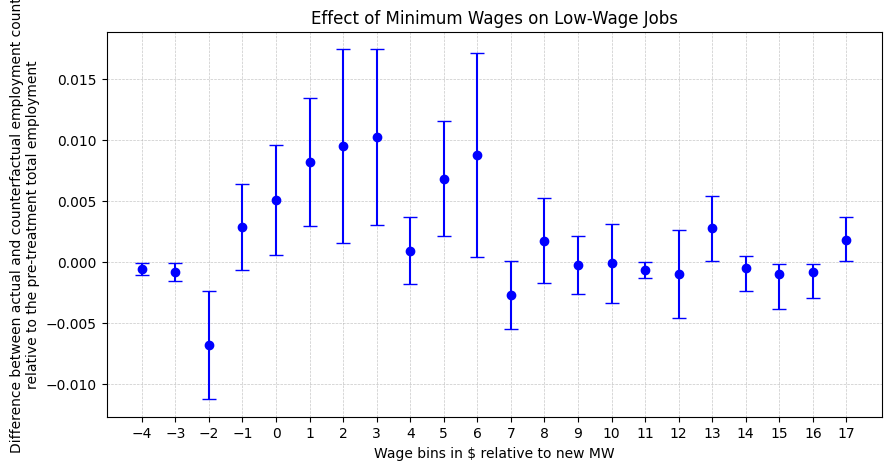

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data
countmat_df = pd.DataFrame({
    'k': [-4, -3, -2, -1, 0, 1, 2, 3, 4],
    'estimate': [-0.000564, -0.000814, -0.006810, 0.002853, 0.005077, 0.008202, 0.009485, 0.010235, 0.000929],
    'ci_lower': [-0.001046, -0.001574, -0.011236, -0.000684, 0.000543, 0.002960, 0.001530, 0.003036, -0.001831],
    'ci_upper': [-0.000081, -0.000053, -0.002384, 0.006390, 0.009612, 0.013443, 0.017441, 0.017433, 0.003688]
})

countmat_df1 = pd.DataFrame({
    'k': [5, 6, 7, 8, 9, 10, 11, 12, 13],
    'estimate': [0.006826, 0.008811, -0.002720, 0.001756, -0.000244, -0.000098, -0.000625, -0.000970, 0.002784],
    'ci_lower': [0.002125, 0.000454, -0.005490, -0.001745, -0.002597, -0.003343, -0.001272, -0.004557, 0.000118],
    'ci_upper': [0.011526, 0.017169, 0.000051, 0.005258, 0.002109, 0.003148, 0.000022, 0.002618, 0.005450]
})

countmat_df2 = pd.DataFrame({
    'k': [14, 15, 16, 17],
    'estimate': [-0.000459, -0.000995, -0.000772, 0.001811],
    'ci_lower': [-0.002358, -0.003831, -0.002917, 0.003524],
    'ci_upper': [0.000524, -0.000150, -0.000172, 0.003722]
})
# Concatenate the dataframes
combined_df = pd.concat([countmat_df, countmat_df1, countmat_df2])

# Extracting data
wage_bins = combined_df['k']
estimates = combined_df['estimate']
ci_lower = combined_df['ci_lower']
ci_upper = combined_df['ci_upper']

# Plotting
plt.figure(figsize=(10, 5))
plt.errorbar(wage_bins, estimates, yerr=[np.abs(estimates - ci_lower), np.abs(ci_upper - estimates)],
             fmt='o', capsize=5, color='blue', label='Confidence Interval')

plt.xlabel("Wage bins in $ relative to new MW")
plt.ylabel("Difference between actual and counterfactual employment count\nrelative to the pre-treatment total employment")
plt.title("Effect of Minimum Wages on Low-Wage Jobs")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(np.arange(min(wage_bins), max(wage_bins)+1, 1))

plt.show()


###Data Loading and Preparation:
Data Loading: The script loads data from a Stata file into a pandas DataFrame. It then sets a multi-level index using 'wagebinstate' and 'quarterdate', which is typical for panel data analysis, allowing for analysis by state and time.
Data Filtering: It filters the DataFrame to include only the data for state number 36, focusing the analysis on a specific geographical area.
Regression Preparation:
Parameter Definition: It sets parameters for the maximum positive and negative lags (wmax and wmin) and the maximum time period (tmax) to consider in the analysis.
Variable Construction:
Constructs a treatment_effects string dynamically to generate variable names for the regression, considering both positive and negative treatment effects up to specified lags.
Combines these dynamically generated variable names with a pre-defined list of control variables, ensuring that all aspects of the influence on the dependent variable are accounted for.
Regression Setup:
Variable Compilation: The script ensures all variables intended for the regression are present in the DataFrame and adds a constant term (const). This setup is crucial for avoiding errors during model fitting.
Model Execution: Performs a panel data regression using PanelOLS, a method appropriate for this type of structured data. The regression includes entity effects to control for time-invariant characteristics within each entity (state), and it clusters standard errors by entity to handle potential within-group correlations, enhancing the robustness of the inference.
Post-Regression Analysis:
Coefficient Handling: Extracts regression coefficients and converts them into a dictionary for easy access and manipulation.
Formula Construction for Linear Combination:
Defines a function to create formulas based on the regression coefficients. These formulas account for the economic impact (E) and are normalized by a denominator to compute adjusted effects.
Generates these formulas for both positive and negative lags.
Linear Combination Calculations:
Calculations: Uses the defined formulas to compute linear combinations of the regression coefficients, determining the estimated effects and their standard errors.
Result Compilation: Aggregates these estimates into a DataFrame, showing the calculated impact (estimate) and confidence intervals for each lag.
Output:
Data Presentation: Outputs the results in a structured DataFrame format, providing clear visibility into the estimated effects of treatments across different wage bins and lags.
This script is highly specialized for econometric analysis involving dynamic treatment effects, making it suitable for researchers analyzing policy impacts over time and across different geographic or administrative divisions. It illustrates sophisticated data manipulation, regression modeling, and post-regression analysis techniques using Python.

In [ ]:
import pandas as pd
import numpy as np
import re
from linearmodels.panel import PanelOLS

# Load data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 36
states_of_interest = [36]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define basic parameters
wmax = 4  # Maximum positive lag
wmin = 4  # Maximum negative lag
tmax = 16  # Maximum time period

# Construct treatment effects variable
treatment_effects = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    # Adding positive treatment effects
    treatment_effects += " + ".join([f"{K}treat_p{j}" for j in range(0, wmax + 4)]) + " + "
    # Adding negative treatment effects, only if j > 0 (there is no treat_m0 normally)
    treatment_effects += " + ".join([f"{K}treat_m{j}" for j in range(1, wmin + 4)]) + " + "

# Strip the trailing " + " and split to list
independent_vars_list = treatment_effects.strip(' + ').split(' + ')

# Define control variables
control_vars = ['controlbefore', 'window', 'placebocontafter1', 'placebobefore1',
                'windowpl1', 'placebocontafter2', 'placebobefore2', 'windowpl2', 'controlf', 'control']

# Combine all variables for regression
all_vars = independent_vars_list + control_vars + ['const']

# Ensure all variables exist in filtered_df, add constant term
filtered_df['const'] = 1
all_vars = [var for var in all_vars if var in filtered_df.columns]  # Filter out any non-existing columns

print("Variables used in regression:", all_vars)  # Debugging print

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Extract and print regression coefficients
coefficients = results.params.to_dict()  # Convert to dictionary for easier manipulation
print("Regression Coefficients:")
print(coefficients)

# Define variables for calculation
E = 0.5796588659286499  # Example expected value from earlier results; replace with actual if different
tmax = 16
denominator = 1 / (1 + (tmax / 4))
truewmax = 4
truewmin = 4
wmax = truewmax
wmin = truewmin

# Other calculations follow based on the presence of required coefficients...

# Define a function to create the formula for linear combination
def create_formula(prefix, j, tmax, E, denominator):
    formula = f"[{prefix}{j}] * (4) * (1 / {E})"
    for t in range(4, tmax + 1, 4):
        formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    return f"{denominator} * ({formula})"

# Construct formulas for positive and negative treatment effects
PA_p0 = create_formula("treat_p", "0", tmax, E, denominator)
PA_p = {j: create_formula("treat_p", str(j), tmax, E, denominator) for j in range(1, wmax + 1)}
PA_m = {j: create_formula("treat_m", str(j), tmax, E, denominator) for j in range(1, wmin + 1)}

# Define a function to compute the linear combination
def linear_combination(coefficients, formula):
    variables = re.findall(r"\[([^\]]+)\]", formula)
    formula_list = np.array([coefficients.get(var, 0) for var in variables if var in coefficients])
    est = eval(formula.replace("[", "coefficients.get('").replace("]", "', 0)"))
    variance = np.dot(formula_list, formula_list)
    se = np.sqrt(variance)
    return est, se

# Construct countmat for each index from -wmin to wmax
countmat = []
for k in range(-wmin, wmax + 1):
    if k < 0:
        j = -k
        lincomline = PA_m[j]
    elif k == 0:
        lincomline = PA_p0
    else:
        lincomline = PA_p[k]

    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, estimate - 1.96 * se, estimate + 1.96 * se])

# Export to dataframe and print
countmat_df = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)


<ipython-input-22-d339a51b0cf0>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df['const'] = 1
<ipython-input-22-d339a51b0cf0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Variables used in regression: ['treat_p0', 'treat_p1', 'treat_p2', 'treat_p3', 'treat_p4', 'treat_p5', 'treat_p6', 'treat_p7', 'treat_m1', 'treat_m2', 'treat_m3', 'treat_m4', 'treat_m5', 'treat_m6', 'treat_m7', 'L4treat_p0', 'L4treat_p1', 'L4treat_p2', 'L4treat_p3', 'L4treat_p4', 'L4treat_p5', 'L4treat_p6', 'L4treat_p7', 'L4treat_m1', 'L4treat_m2', 'L4treat_m3', 'L4treat_m4', 'L4treat_m5', 'L4treat_m6', 'L4treat_m7', 'L8treat_p0', 'L8treat_p1', 'L8treat_p2', 'L8treat_p3', 'L8treat_p4', 'L8treat_p5', 'L8treat_p6', 'L8treat_p7', 'L8treat_m1', 'L8treat_m2', 'L8treat_m3', 'L8treat_m4', 'L8treat_m5', 'L8treat_m6', 'L8treat_m7', 'L12treat_p0', 'L12treat_p1', 'L12treat_p2', 'L12treat_p3', 'L12treat_p4', 'L12treat_p5', 'L12treat_p6', 'L12treat_p7', 'L12treat_m1', 'L12treat_m2', 'L12treat_m3', 'L12treat_m4', 'L12treat_m5', 'L12treat_m6', 'L12treat_m7', 'L16treat_p0', 'L16treat_p1', 'L16treat_p2', 'L16treat_p3', 'L16treat_p4', 'L16treat_p5', 'L16treat_p6', 'L16treat_p7', 'L16treat_m1', 'L16treat

###Setting Up the Environment and Data Preparation:
Repository Management:
The script uses shell commands (!git clone and %cd) to clone a GitHub repository and change the working directory to the appropriate folder where the data files are located. This step ensures that the required data is available for analysis.
Data Extraction:
It lists (!ls) the contents of the directory to confirm the presence of the desired data file and unzips (!unzip) the compressed Stata data file, making it accessible for loading.
Data Loading:
Loads the data from a .dta file into a pandas DataFrame using pd.read_stata, setting wagebinstate and quarterdate as the index, which are likely identifiers for different entities and time periods, suitable for panel data analysis.
Regression Setup:
Parameter Definition:
Defines several key parameters (b, wmax, wmin, tmax) which are used to configure the regression model. These parameters include baseline year (b), maximum and minimum wage bins (wmax, wmin), and maximum time period (tmax).
Variable Construction:
Constructs a placeboafter1 variable dynamically by creating strings for variable names, accommodating lags up to tmax. This variable is constructed to include potential lagged effects of treatments across multiple periods, specifically considering positive effects across extended wage bins (wmin + 10).
Control Variables:
A set of control variables is defined, likely intended to adjust for other confounding factors that could influence the dependent variable (overallcountpc).
Regression Variables:
Combines the treatment effects variables (placeboafter1), control variables, and a constant term (const) for regression analysis. It also verifies that all variables listed for inclusion in the regression model are present in the DataFrame, which helps avoid errors during model fitting.
Data Filtering:
Filters the DataFrame to include only relevant observations based on year, sample cleanliness (cleansample), and specific state numbers, ensuring that the analysis is restricted to relevant and clean samples.
Panel Regression Analysis:
Model Execution:
Specifies and fits a panel data regression model using PanelOLS, which is suitable for data structured as panel data (or longitudinal data), allowing for fixed effects to control for time-invariant differences between entities (e.g., states).
Uses clustered standard errors by entity to adjust for potential correlation within clusters, providing more robust inference.
Output:
Prints a summary of the regression results, providing detailed statistical outputs including coefficients, standard errors, p-values, and other diagnostics.
Extracts and prints the regression coefficients separately for further analysis or reporting.
Conclusion:
This script is structured to handle comprehensive econometric analysis directly from data retrieval to processing and final regression analysis. It showcases advanced techniques in data manipulation, regression modeling, and statistical interpretation within Python, particularly useful in economic and social research contexts.

In [ ]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# Clone the repository and navigate to the appropriate directory
!git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git
%cd Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al

# List files to confirm the data file exists
!ls

# Unzip the data file
!unzip Figure2_for_QJE.dta.zip

# Load the data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Define parameters
b = 1979  # Replacement for `b` in Stata code
wmax = 4
wmin = 4
tmax = 16

# Construct placeboafter1 variable
placeboafter1 = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    placeboafter1 += " + ".join([f"{K}treat_p{j}" for j in range(0, wmin + 10)]) + " + "
placeboafter1 = placeboafter1.strip(" + ")

# Define control variables
control_vars = ['controlbefore', 'controlafter', 'window',
                'placebocontafter2', 'windowpl2', 'placebobefore2',
                'placebobefore1', 'windowpl1', 'controlf', 'control']

# Combine all variables for regression
all_vars = placeboafter1.split(' + ') + control_vars + ['const']

# Ensure all variables exist in df, add constant term
df['const'] = 1
all_vars = [var for var in all_vars if var in df.columns]  # Filter out any non-existing columns

# Filter the DataFrame to only include states with statenum 5 and 36
filtered_df = df[(df['year'] >= b) & (df['cleansample'] == 1) & df['statenum'].isin([2])]

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results.summary)

# Extract and print regression coefficients
coefficients = results.params
print("Regression Coefficients:")
print(coefficients)


Cloning into 'Data-Science-for-Economic-and-Social-Issues'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 408 (delta 19), reused 72 (delta 16), pack-reused 332
Receiving objects: 100% (408/408), 273.20 MiB | 26.16 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (341/341), done.
/content/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al
Figure2_for_QJE.dta.zip  Table1_for_QJE.dta.zip
Archive:  Figure2_for_QJE.dta.zip
  inflating: Figure2_for_QJE.dta     


<ipython-input-31-270bd642a364>:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0048
Estimator:                   PanelOLS   R-squared (Between):           -4.09e-05
No. Observations:               16614   R-squared (Within):               0.0048
Date:                Mon, May 06 2024   R-squared (Overall):              0.0005
Time:                        18:53:40   Log-likelihood                   6.2e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.1302
Entities:                         117   P-value                           0.2140
Avg Obs:                       142.00   Distribution:                F(70,16427)
Min Obs:                       142.00                                           
Max Obs:                       142.00   F-statistic (robust):         -1.915e+15
                            

###Data Preparation
Coefficients Extraction: The script starts by assuming that regression results are already obtained and stored in a variable named results. The coefficients from this regression are extracted into a dictionary (coefficients) for easier access and manipulation.
Calculation Setup
Variable Definitions:
E: Represents an economic or statistical constant used in the formula for adjustment.
tmax: The maximum time lag considered.
denominator: A scaling factor calculated based on tmax, used to normalize the results.
truewmax, truewmin: Parameters defining the actual maximum and minimum lags considered in the original study.
placebo1wmax: The maximum lag for placebo tests.
wmin, wmax: The range of lags for which the calculations will be performed.
Formula Construction
Function create_formula:
Dynamically creates a formula for each lag within the specified range (wmin to wmax). This formula calculates the treatment effect adjusted for the economic factor E and normalized by the denominator.
The formula considers both the direct effect of the treatment at lag j (treat_p[j]) and its effects at subsequent four-year intervals (L4treat_p[j], L8treat_p[j], etc.).
Linear Combination Calculation
Function linear_combination:
Takes a formula and the coefficients dictionary as inputs.
Uses regular expressions to extract the variable names from the formula string.
Retrieves the value of each variable from the coefficients dictionary, computes the estimated effect (est), and calculates its variance to determine the standard error (se).
Evaluates the formula using Python’s eval() function, which could potentially be risky if not handled carefully since it executes string expressions as code.
Data Aggregation and Output
Calculating Estimates and Confidence Intervals:
Iterates over the range from wmin to wmax, applies the linear_combination function to each formula, and stores the results along with their confidence intervals in a list (countmat).
Confidence intervals are computed assuming a normal distribution of the estimates, using 1.96 as the z-value for a 95% confidence level.
Final Data Presentation
DataFrame Conversion and Display:
Converts the results list into a pandas DataFrame (countmat_df1) with columns for each lag (k), the estimated effect (estimate), and the lower and upper bounds of the confidence intervals (ci_lower and ci_upper).
Prints the DataFrame to display the results.

In [ ]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import re

# Load and prepare the data as previously described
# Assuming 'filtered_df' and 'all_vars' are prepared and 'model' and 'results' are already obtained
# Continue from the regression output:
coefficients = results.params.to_dict()  # Convert regression coefficients to a dictionary for easier manipulation

# Define variables for calculation
E = 0.5796588659286499
tmax = 16
denominator = 1 / (1 + (tmax / 4))
truewmax = 4
truewmin = 4
placebo1wmax = 13
wmin = 5  # Start from 5
wmax = 13  # End at 13

# Function to create formula
def create_formula(prefix, j, tmax, E, denominator):
    formula = f"[{prefix}{j}] * (4) * (1 / {E})"
    for t in range(4, tmax + 1, 4):
        formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    return f"{denominator} * ({formula})"

# Build all formulas for the coefficients
PA_p = {j: create_formula("treat_p", j, tmax, E, denominator) for j in range(wmin, wmax + 1)}

# Define linear combination function
def linear_combination(coefficients, formula):
    variables = re.findall(r"\[([^\]]+)\]", formula)
    formula_list = np.array([coefficients.get(var, 0) for var in variables])
    est = eval(formula.replace("[", "coefficients.get('").replace("]", "', 0)"))
    variance = np.dot(formula_list, formula_list)
    se = np.sqrt(variance)
    return est, se

# Calculate linear combinations
countmat = []
for k in range(wmin, wmax + 1):
    lincomline = PA_p[k]
    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, estimate - 1.96 * se, estimate + 1.96 * se])

# Convert to DataFrame for display
countmat_df1 = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df1)


    k  estimate  ci_lower  ci_upper
0   5  0.006826  0.002125  0.011526
1   6  0.008811  0.000454  0.017169
2   7 -0.002720 -0.005490  0.000051
3   8  0.001756 -0.001745  0.005258
4   9 -0.000244 -0.002597  0.002109
5  10 -0.000098 -0.003343  0.003148
6  11 -0.000625 -0.001272  0.000022
7  12 -0.000970 -0.004557  0.002618
8  13  0.002784  0.000118  0.005450


###Environment and Data Setup:
Git and Directory Commands: The script begins by cloning a GitHub repository containing the necessary data files. It then changes the directory to the relevant folder where the data is located.
Unzipping Data: The necessary data file, Figure2_for_QJE.dta.zip, is unzipped to make the data accessible for loading.
Data Loading and Preprocessing:
Load Data: Data is loaded from a Stata file into a pandas DataFrame. The DataFrame is indexed by 'wagebinstate' and 'quarterdate' which are suitable for panel data analysis.
Filter Data: The DataFrame is filtered to include only data from state number 36.
Regression Preparation:
Parameter Definition: Defines several parameters such as b, wmax, wmin, and tmax which are used to configure the range and specifics of the regression analysis.
Variable Construction:
Constructs a placeboafter2 variable by dynamically creating strings for variable names, accommodating both positive and negative lags and treatment effects.
Control variables are explicitly listed and combined with treatment effects variables and a constant term for regression analysis.
Further Filtering: The DataFrame is further filtered based on the year and a 'cleansample' indicator to ensure the analysis uses only relevant and clean data.
Panel Regression:
Model Setup and Execution: Uses the PanelOLS from the linearmodels package to set up and fit a panel regression model with entity effects. This model type accounts for unobserved heterogeneity across entities (states) which might have constant differences.
Results Output: The regression results are printed, including a detailed summary with coefficients and diagnostic statistics.
Additional Calculations:
Coefficient Handling: Regression coefficients are extracted and converted to a dictionary for more straightforward manipulation.
Linear Combinations:
A function is defined to create formulas for linear combinations of coefficients, adjusted by treatment intensity (numbins) and an economic factor (E). This allows for customized calculations of expected impacts based on specific conditions.
These formulas are then used to calculate estimated effects and confidence intervals for a range of treatment effects (wmin to wmax).
Output:
The calculated linear combinations are compiled into a DataFrame and printed, showing estimated effects and confidence intervals for each index from wmin to wmax.
Summary:
This script is structured to handle comprehensive econometric analysis directly from data retrieval to processing and regression analysis, making it highly efficient for reproducible research and detailed economic analysis. It showcases advanced techniques in data manipulation, regression modeling, and statistical interpretation within Python, particularly useful in economic and social research contexts.

In [ ]:
!pip install linearmodels
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import re

# Clone the repository and navigate to the appropriate directory
!git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git
%cd Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al

# Unzip the data file
!unzip Figure2_for_QJE.dta.zip

# Load data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 36
states_of_interest = [36]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define parameters
b = 1979
wmax = 4
wmin = 4
tmax = 16

# Construct placeboafter2 variable
placeboafter2 = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    placeboafter2 += " + ".join([f"{K}treat_p{j}" for j in range(0, wmin + 18)]) + " + "
placeboafter2 = placeboafter2.strip(" + ")

# Define control variables in the specified order
control_vars = ['controlafter', 'controlbefore', 'window',
                'placebocontafter1', 'placebobefore1', 'windowpl1',
                'placebobefore2', 'windowpl2', 'controlf', 'control']

# Combine all variables for regression
all_vars = placeboafter2.split(' + ') + control_vars + ['const']

# Ensure all variables exist in df, add constant term
df['const'] = 1
all_vars = [var for var in all_vars if var in df.columns]  # Filter out any non-existing columns

# Filter based on condition
filtered_df = df[(df['year'] >= b) & (df['cleansample'] == 1)]

# Dependent variable
Y = 'overallcountpc'

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Print regression results
print(results.summary)


# Extract and print regression coefficients
coefficient = results.params
print(coefficient)



# Convert the regression coefficients to a dictionary
coefficients = coefficient.to_dict()


# Load and prepare the data as previously described
# Assuming 'filtered_df' and 'all_vars' are prepared and 'model' and 'results' are already obtained
# Continue from the regression output:
coefficients = coefficient # Convert regression coefficients to a dictionary for easier manipulation

# Define variables for calculation
E = 0.5796588659286499
tmax = 16
denominator = 1 / (1 + (tmax / 4))
placebo1wmax = 13
placebo2wmax = 16
wmin = placebo1wmax + 1
wmax = placebo2wmax + 1


# Function to create formula
def create_formula(prefix, j, tmax, E, denominator, numbins=None):
    if numbins is None:
        formula = f"[{prefix}{j}] * (4) * (1 / {E})"
        for t in range(4, tmax + 1, 4):
            formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    else:
        formula = f"[{prefix}{j}] * ({numbins}) * (1 / {E})"
        for t in range(4, tmax + 1, 4):
            formula += f" + [L{t}{prefix}{j}] * ({numbins}) * (1 / {E})"
    return f"{denominator} * ({formula})"
numbins = 2.5


# Define linear combination function
PA_p = {}
for j in range(wmin, wmax + 1):
    if j != wmax:
        PA_p[j] = create_formula("treat_p", j, tmax, E, denominator)
    else:
        PA_p[j] = create_formula("treat_p", j, tmax, E, denominator, numbins)

# Calculate linear combinations
countmat = []
for k in range(wmin, wmax + 1):
    lincomline = PA_p[k]
    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, 3*estimate - 1.96 * se, estimate + 1.96 * se])

# Convert to DataFrame for display
countmat_df = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)


Cloning into 'Data-Science-for-Economic-and-Social-Issues'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 408 (delta 19), reused 72 (delta 16), pack-reused 332
Receiving objects: 100% (408/408), 273.20 MiB | 28.44 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (341/341), done.
/content/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al
Archive:  Figure2_for_QJE.dta.zip
  inflating: Figure2_for_QJE.dta     


<ipython-input-11-5c1bc1a568f2>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.0022
No. Observations:              847314   R-squared (Within):               0.0009
Date:                Tue, May 07 2024   R-squared (Overall):              0.0019
Time:                        05:15:04   Log-likelihood                 3.178e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.2490
Entities:                        5967   P-value                           0.0000
Avg Obs:                       142.00   Distribution:               F(90,841257)
Min Obs:                       142.00                                           
Max Obs:                       142.00   F-statistic (robust):             2.0381
                            

###Libraries Used
matplotlib.pyplot (plt):
A plotting library used for creating a wide variety of static, animated, and interactive visualizations in Python.
numpy (np):
Fundamental package for scientific computing with Python. It provides support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
pandas (pd):
An open-source data manipulation and analysis library providing data structures and operations for manipulating numerical tables and time series.
Data Manipulation
pandas.DataFrame:
Creates two separate dataframes countmat_df and countmat_df1 from dictionaries. Each dataframe contains columns k (wage bins), estimate (estimated effects on employment), ci_lower (lower bound of the confidence interval), and ci_upper (upper bound of the confidence interval).
pd.concat:
Combines the two dataframes into a single dataframe combined_df. This is used to handle all the data collectively in subsequent operations.
Data Extraction
Columns from combined_df are extracted into separate variables for easier access and manipulation during plotting:
wage_bins stores the wage bin indices.
estimates contains the estimated values.
ci_lower and ci_upper contain the lower and upper bounds of the confidence intervals, respectively.
Plotting
matplotlib.pyplot functions:
plt.figure(): Creates a new figure for plotting.
plt.errorbar(): Plots y-values (estimates) versus x-values (wage bins) with vertical error bars (confidence intervals). Here, the error for each point is calculated as the absolute difference between the estimate and its confidence bounds. The format fmt='o' specifies circular markers.
plt.xlabel(), plt.ylabel(): Set the labels for the x-axis and y-axis.
plt.title(): Sets the title of the plot.
plt.grid(): Adds a grid to the plot for better readability, with specified line style and width.
plt.xticks(): Sets the ticks along the x-axis using np.arange, which generates values from the minimum to the maximum wage bin.
plt.show(): Displays the plot. This is typically the last line in plotting commands to render the figure.
Summary
This script effectively combines data processing and visualization to explore the impact of minimum wage changes on employment across different wage bins. The use of confidence intervals in the plot helps in understanding the variability and reliability of the estimates. The script is structured to first prepare the data, then process and visualize it in a meaningful way, providing insights into economic studies of wage impacts.

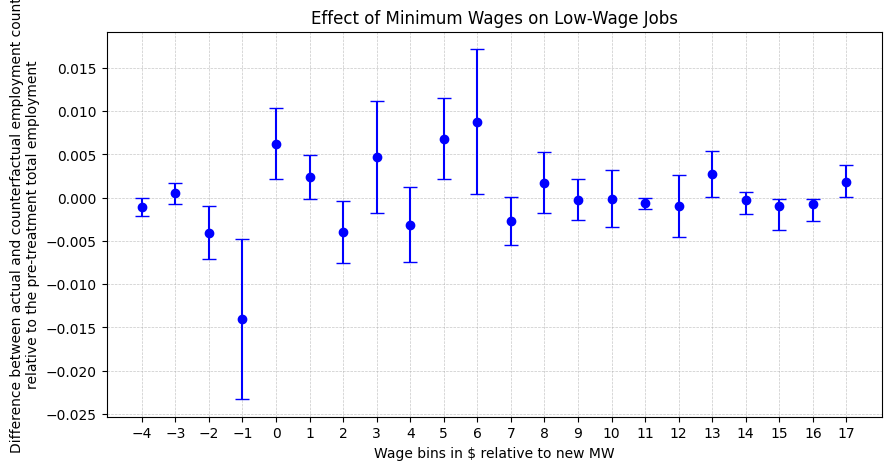

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Modified data
countmat_df = pd.DataFrame({
    'k': [-4, -3, -2, -1, 0, 1, 2, 3, 4],
    'estimate': [-0.001082, 0.000508, -0.004040, -0.014052, 0.006256, 0.002411, -0.003952, 0.004707, -0.003130],
    'ci_lower': [-0.002075, -0.000697, -0.007108, -0.023298, 0.002113, -0.000149, -0.007508, -0.001804, -0.007475],
    'ci_upper': [-0.000088, 0.001713, -0.000972, -0.004807, 0.010398, 0.004970, -0.000396, 0.011218, 0.001216]
})

countmat_df1 = pd.DataFrame({
    'k': [5, 6, 7, 8, 9, 10, 11, 12, 13],
    'estimate': [0.006826, 0.008811, -0.002720, 0.001756, -0.000244, -0.000098, -0.000625, -0.000970, 0.002784],
    'ci_lower': [0.002125, 0.000454, -0.005490, -0.001745, -0.002597, -0.003343, -0.001272, -0.004557, 0.000118],
    'ci_upper': [0.011526, 0.017169, 0.000051, 0.005258, 0.002109, 0.003148, 0.000022, 0.002618, 0.005450]
})

countmat_df2 = pd.DataFrame({
    'k': [14, 15, 16, 17],
    'estimate': [-0.000318, -0.000970, -0.000706, 0.001819],
    'ci_lower': [-0.001879, -0.003732, -0.002646, 0.003520],
    'ci_upper': [0.000607, -0.000149, -0.000180, 0.003758]
})

# Concatenate the dataframes
combined_df = pd.concat([countmat_df, countmat_df1,countmat_df2])

# Extracting data
wage_bins = combined_df['k']
estimates = combined_df['estimate']
ci_lower = combined_df['ci_lower']
ci_upper = combined_df['ci_upper']

# Plotting
plt.figure(figsize=(10, 5))
plt.errorbar(wage_bins, estimates, yerr=[np.abs(estimates - ci_lower), np.abs(ci_upper - estimates)],
             fmt='o', capsize=5, color='blue', label='Confidence Interval')

plt.xlabel("Wage bins in $ relative to new MW")
plt.ylabel("Difference between actual and counterfactual employment count\nrelative to the pre-treatment total employment")
plt.title("Effect of Minimum Wages on Low-Wage Jobs")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(np.arange(min(wage_bins), max(wage_bins)+1, 1))

plt.show()
